In [1]:
import numpy as np
import flopy

Convert Tutorial 01 model into an unconfined, transient flow model with time varying boundaries. Instead of using constant heads for the left and right boundaires (by setting ibound to -1), we will use general head boundaires. We will have the model consider the following conditions:

- Initial conditions  - head is 10.0 everywhere
- Period 1 (1 day)    - steady state with left and right GHB stage = 10
- Period 2 (100 days) - left GHB with stage = 10, right GHB stage set to 0
- Period 3 (100 days) - pumping well at model center with rate = -500, left and right GHB = 10 and 0 respectively
  
### 1. Create Flopy Model Object

### 2. Discretization
##### 2.1 Define model domain and create MODFLOW grid

In [4]:
Lx   = 1000.0
Ly   = 1000.0
ztop = 10.0
zbot = -50.0
nlay = 1
nrow = 10
ncol = 10
delr = Lx / ncol
delc = Ly / nrow
delv = (ztop - zbot) / nlay
botm = np.linspace(ztop, zbot, nlay + 1)
hk   = 1.0
vk   = 1.0
sy   = 0.1
ss   = 1.0e-4
laytyp = 1

##### Variable for the BAS package (*note the changes from the MODFLOW tutorial 01*)

In [5]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
strt   = 10.0 * np.ones((nlay, nrow, ncol), dtype=np.float32)

### 3. Define stress periods
To create a model with multiple stress periods, we need to define nper, perlen, nstp, and steady. This is done in the following block in a manner that allows us to pass these variables directly to the discretization object:

In [3]:
nper   = 3
perlen = [1, 100, 100]
nstp   = [1, 100, 100]
steady = [True, False, False]

#### 4. Create Time-Invariant Flopy Objects
With this information, we can now create the static flopy objects that do not change with time:

In [6]:
modelname = "tutorial02_mf"
mf        = flopy.modflow.Modflow(modelname, exe_name='../../basinModel/mf2005')
dis       = flopy.modflow.ModflowDis(
            mf,
            nlay,
            nrow,
            ncol,
            delr=delr,
            delc=delc,
            top=ztop,
            botm=botm[1:],
            nper=nper,
            perlen=perlen,
            nstp=nstp,
            steady=steady
            )
bas       = flopy.modflow.ModflowBas(
            mf,
            ibound=ibound,
            strt=strt
            )
lpf       = flopy.modflow.ModflowLpf(
            mf,
            hk=hk,
            vka=vk,
            sy=sy,
            laytyp=laytyp,
            ipakcb=53
            )
pcg       = flopy.modflow.ModflowPcg(mf)

### 5. Transient General-Head Boundary package (GHB)
At this point, our model is ready to add our transient boundary packages. First, we will cretae the GHB object.

The key to creating FLopy transient boundary packages is recognizing that the boundary data is stored in a dictionary with key values equal to the Zero-based stress period number and values equal to the boundary conditions for that stress period. For a GHB, the values can be a two-dimensional nested list of <font color ="orange">[layer, row, column, stage, conductance]</font>.

In [8]:
stageleft  = 10.0
stageright = 10.0
bound_sp1  = []
for il in range(nlay):
    condleft  = hk * (stageleft - zbot) * delc
    condright = hk * (stageright - zbot) * delc
    for ir in range(nrow):
        bound_sp1.append([il, ir, 0, stageleft, condleft])
        bound_sp1.append([il, ir, ncol - 1, stageright, condright])
print("Adding", len(bound_sp1), "GHBs for stress period 1")

Adding 20 GHBs for stress period 1


In [27]:
# make list for stress period 2
stageleft  = 10.0
stageright = 0.0
condleft   = hk * (stageleft - zbot) * delc
condright  = hk * (stageright - zbot) * delc
bound_sp2  = []
for il in range(nlay):
    for ir in range(nrow):
        bound_sp2.append([il, ir, 0, stageleft, condleft])
        bound_sp2.append([il, ir, ncol - 1, stageright, condright])
print("Adding", len(bound_sp2), "GHBs for stress period 2.")

Adding 20 GHBs for stress period 2.


In [28]:
# We do not need to add a dictionary entry for stress period 3.
# Flopy will automatically take the list from stress period 2 and apply it
# to the end of the simulation
stress_period_data = {0: bound_sp1, 1: bound_sp2}

In [29]:
# Create the flopy ghb object
ghb = flopy.modflow.ModflowGhb(
      mf,
      stress_period_data=stress_period_data
      )

### 6. Transient well package (WEL)
Now we can create the well package object

In [30]:
# Create the well package, remember to use zero-based layer, row, column indices!
pumping_rate = -500.0
wel_sp1 = [[0, nrow/2 - 1, ncol/2 - 1, 0.0]]
wel_sp2 = [[0, nrow/2 - 1, ncol/2 - 1, 0.0]]
wel_sp3 = [[0, nrow/2 - 1, ncol/2 - 1, pumping_rate]]
stress_period_data = {0: wel_sp1, 1: wel_sp2, 2: wel_sp3}
wel = flopy.modflow.ModflowWel(
      mf,
      stress_period_data=stress_period_data
      )

### 7. Output control
Here we create the output control package object

In [31]:
stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = [
            "save head",
            "save drawdown",
            "save budget",
            "print head",
            "print budget"
        ]
oc = flopy.modflow.ModflowOc(
     mf,
     stress_period_data=stress_period_data,
     compact=True
)

### 8. Running the model
Run the model with the run_model method, which returns a success flag and the stream of output. With run_model, we have some finer control that allows us to suppress the output

In [32]:
# Write the model input files
mf.write_input()

In [33]:
# Run the model
success, mfoutput = mf.run_model(silent=True, pause=False)
if not success:
    raise Exception("MODFLOW did not terminate normally")

### 9. Post-processing the results
Once again, we can read heads from the MODFLOW binary output file. Included with the HEadFile object are several methods that we will use here:
- <font color="orange">get_times( )</font> will return a list of times contained in the binary head file
- <font color="orange">get_data( )</font> will return a three-dimensional head array for the specified time
- <font color="orange">get_ts( )</font> will return a time series array <font color="orange">[ntimes, headval]</font> for the specified cell
  
Using these methods, we can cretae head plots and hydrographs from the model results

In [34]:
# Imports
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

In [35]:
# Create the headfile and budget file objects
headobj = bf.HeadFile(modelname + ".hds")
times   = headobj.get_times()
cbb     = bf.CellBudgetFile(modelname + ".cbc")

In [36]:
# Setup contour parameters
levels = np.linspace(0, 10, 11)
extent = (delr/2, Lx - delr/2, delc/2, Ly - delc/2)
print("Levels: ", levels)
print("Extent: ", extent)

Levels:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Extent:  (50.0, 950.0, 50.0, 950.0)


In [37]:
# Well point for plotting
wpt = (450, 550)

*****Processing time:  1
Head statistics
  min:  10.0
  max:  10.0
  std:  0.0
*****Processing time:  101
Head statistics
  min:  0.025931068
  max:  9.998436
  std:  3.2574987
*****Processing time:  201
Head statistics
  min:  0.016297927
  max:  9.994038
  std:  3.1544707


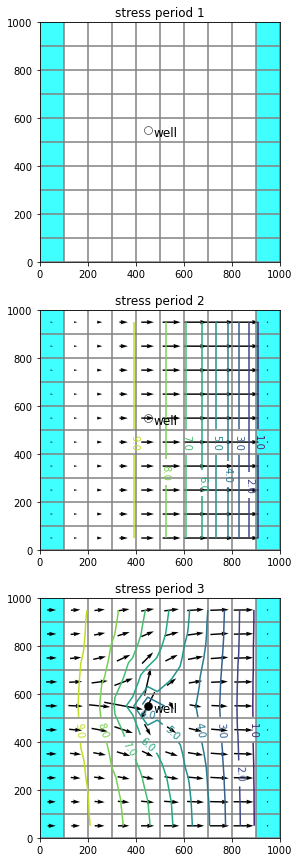

In [38]:
# Make the plots
fig = plt.figure(figsize=(5,15))
mytimes = [1, 101, 201]

for iplot, time in enumerate(mytimes):
    print("*****Processing time: ", time)
    head = headobj.get_data(totim=time)
    # Print statistics
    print("Head statistics")
    print("  min: ", head.min())
    print("  max: ", head.max())
    print("  std: ", head.std())

    # Extract flow right face and flow front face
    frf = cbb.get_data(text="FLOW RIGHT FACE", totim=time)[0]
    fff = cbb.get_data(text="FLOW FRONT FACE", totim=time)[0]

    # Create a map for this time
    ax = fig.add_subplot(len(mytimes), 1, iplot +1, aspect="equal")
    ax.set_title("stress period " + str(iplot+1))

    pmv = flopy.plot.PlotMapView(model=mf, layer=0, ax=ax)
    qm = pmv.plot_ibound()
    lc = pmv.plot_grid()
    qm = pmv.plot_bc("GHB", alpha=0.5)
    if head.min() != head.max():
        cs = pmv.contour_array(head, levels=levels)
        plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")
        quiver = pmv.plot_vector(frf, fff)

    mfc = "None"
    if (iplot + 1) == len(mytimes):
        mfc = "black"
    ax.plot(
        wpt[0],
        wpt[1],
        lw=0,
        marker="o",
        markersize=8,
        markeredgewidth=0.5,
        markeredgecolor='black',
        markerfacecolor=mfc,
        zorder=9
        )
    ax.text(wpt[0] + 25, wpt[1] - 25, "well", size=12, zorder=12)

### 10. Create a hydrograph

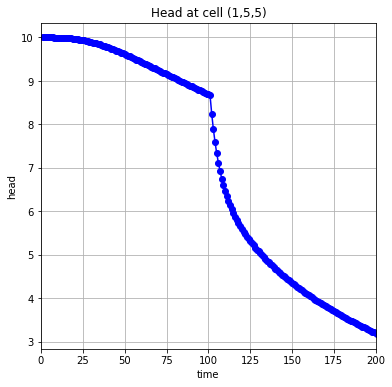

In [44]:
# Plot the head vs time
idx = (0, int(nrow/2) - 1, int(ncol/2) -1)
ts  = headobj.get_ts(idx)
fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(1,1,1)
ttl = "Head at cell ({0},{1},{2})".format(idx[0] + 1, idx[1] + 1, idx[2] + 1)
ax.set_title(ttl)
ax.set_xlabel("time")
ax.set_ylabel("head")
ax.grid("k-")
ax.set_xlim(0, 200)
ax.plot(ts[:, 0], ts[:, 1], "bo-")
plt.show()